In [1]:
import os
base_path = os.path.dirname(os.path.abspath(""))
base_path = base_path + "/headers/"
print(base_path)
header_path = base_path + 'header_data_treatment.ipynb'
%run $header_path

C:\Users\common\projet_3_lru\sorting_univ\script/headers/
initalizing spark session 


In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler

In [3]:
panel_smoothed = spark.read.parquet('file:\\' + save_path + 'panel_smoothed_w_theses.parquet')

In [4]:
panel_smoothed.show()

+-----------+----+-----------+---------------+-----------+------------------+-------------------+--------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+-----+-------+----+--------------------+----------+---------+----------+-----+------+-----+----------+---------+-----------+------------+----------+--------------------+------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------------+-----------------------------+--------------------+--------------------------+--------------------+-----------------------+--------

In [5]:
panel_smoothed.columns

['author_id',
 'year',
 'inst_id',
 'new_inst_period',
 'period_inst',
 'last_y_inst_period',
 'first_y_inst_period',
 'n_inst_y',
 'publications_raw',
 'citations_raw',
 'avg_rank_source_raw',
 'nr_source_btm_50pct_raw',
 'nr_source_mid_40pct_raw',
 'nr_source_top_20pct_raw',
 'nr_source_top_10pct_raw',
 'nr_source_top_5pct_raw',
 'name',
 'type',
 'city',
 'homepage_url',
 'topic_share',
 'main_topic',
 'parent',
 'fused',
 'uni_pub',
 'cnrs',
 'idex',
 'type_fr',
 'secteur',
 'universite',
 'ecole',
 'public',
 'prive',
 'entry_year',
 'last_year',
 'all_y_in_FR',
 'years_abroad',
 'main_field',
 'author_name',
 'entry_cohort',
 'publications',
 'citations',
 'avg_rank_source',
 'nr_source_btm_50pct',
 'nr_source_mid_40pct',
 'nr_source_top_20pct',
 'nr_source_top_10pct',
 'nr_source_top_5pct',
 'inst_set_this_year',
 'thesis_year',
 'thesis_supervisor',
 'thesis_jury',
 'thesis_referee',
 'thesis_supervisor_inst',
 'thesis_supervisor_parent_inst',
 'thesis_referee_inst',
 'thesis_r

In [6]:
labs_2002_2003 = (panel_smoothed.select(*[col for col in panel_smoothed.columns if (col in ['author_id', 'year','inst_id','main_field','entry_year', 'entry_cohort', 'idex','fused','universite','ecole'
                                                                                            ,'type','name','author_name'])
                                         or ('raw' in col)])
                      .withColumn('entry_year_lab', func.min(func.col('year')).over(Window.partitionBy('inst_id')))
                     .filter( (func.col('entry_year_lab')<=2003) & (func.col('entry_year_lab')>=1965))
                     .filter( func.col('year').between(2002,2003))
                    )
labs_2002_2003.cache()
labs_2002_2003.show()

+-----------+----+----------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-------+---------+-----+-------+----------+-----+----------+----------+-------------------+------------+--------------+
|  author_id|year|   inst_id|publications_raw|citations_raw|avg_rank_source_raw|nr_source_btm_50pct_raw|nr_source_mid_40pct_raw|nr_source_top_20pct_raw|nr_source_top_10pct_raw|nr_source_top_5pct_raw|   name|     type|fused|   idex|universite|ecole|entry_year|main_field|        author_name|entry_cohort|entry_year_lab|
+-----------+----+----------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-------+---------+-----+-------+----------+-----+----------+----------+-------------------+------------+--------------+
|A5006475297|2003|I102475099|              

In [7]:
fields = [row[0] for row in labs_2002_2003.select(func.explode(func.split(func.col('main_field'), ','))).distinct().collect()]

In [8]:
entry_cohorts = [row[0] for row in labs_2002_2003.select('entry_cohort').distinct().collect()]

In [110]:
types  = [row[0] for row in labs_2002_2003.select('type').distinct().collect()]
types

['facility',
 'education',
 'archive',
 'other',
 'nonprofit',
 'healthcare',
 'company',
 'government']

In [111]:
labs_2002_2003_for_features = (labs_2002_2003
                               .select(*labs_2002_2003.columns,
                                       *[(func.col('main_field').contains(field)).cast('double').alias('in_' + field) for field in fields],
                                       *[(func.col('entry_cohort') == cohort).cast('double').alias('cohort_' + str(int(cohort))) for cohort in entry_cohorts],
                                       *[(func.col('year') == year).cast('double').alias('y_' + str(int(year))) for year in range(2002, 2005)],
                                       *[(func.col('type') == type_).cast('double').alias('type_' + type_) for type_ in types],
                                       (~(func.col('idex').contains('annulee') ) & ~(func.col('idex')=='no_idex')).cast('double').alias('has_idex'))

                               .filter(func.col('publications')>0)
                              )
features_col = ['fused','universite','ecole', 'entry_year_lab']+['cohort_' + str(int(cohort)) for cohort in entry_cohorts]+['in_'+ field for field in fields]+ ['type_' + type for type in types]+['y_' + str(int(year)) for year in range(2002, 2005)]


In [112]:
labs_2002_2003_for_features = (labs_2002_2003_for_features
                               .fillna(0, subset=features_col)
                               .select(*[col for col in labs_2002_2003_for_features.columns if col not in features_col],
                                                                  *[func.col(col).cast('double').alias(col) for col in features_col])
                              .withColumn('to_winsorize', func.percentile(func.col('citations_raw'), 0.975, func.lit(1)).over(Window.partitionBy('year','main_field')))
                               .withColumn('citations_raw', func.when(func.col('citations_raw')>func.col('to_winsorize'), func.col('to_winsorize'))
                                           .otherwise(func.col('citations_raw')))
                              )

In [113]:

assembler = VectorAssembler(inputCols=features_col, outputCol="features")
labs_2002_2003_features = assembler.transform(labs_2002_2003_for_features)
labs_2002_2003_features.show()

+-----------+----+-----------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+----------+--------------------+----------+----------+--------------------+------------+--------+-----+----------+-----+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------------+--------------+------------+----------+--------------+---------------+------------+---------------+------+------+------+-----------------+--------------------+
|  author_id|year|    inst_id|publications_raw|citations_raw|avg_rank_source_raw|nr_source_btm_50pct_raw|nr_source

In [114]:
start_time = time.time()
lr = GeneralizedLinearRegression(featuresCol="features", labelCol="citations_raw", family="poisson", predictionCol="y_pred")
model = lr.fit(labs_2002_2003_features)
print(f'Model has run in {round(time.time()-start_time)} sec.')

Model has run in 397 sec.


In [115]:
labs_2002_2003_residualized = model.transform(labs_2002_2003_features).withColumn('residualised_citations', func.round( func.col('citations_raw')-func.col('y_pred'), 2))

In [116]:
labs_2002_2003_residualized.show()

+-----------+----+-----------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+----------+--------------------+----------+----------+--------------------+------------+--------+-----+----------+-----+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------------+--------------+------------+----------+--------------+---------------+------------+---------------+------+------+------+-----------------+--------------------+------------------+----------------------+
|  author_id|year|    inst_id|publications_raw|citations_raw|avg_rank_so

In [117]:
n_f = 10
labs_2002_2003_for_k_means = (labs_2002_2003_residualized
                              .groupBy('inst_id', 'name')
                              .agg(func.percentile(func.col('residualised_citations'), [i/n_f for i in range(0,n_f)], func.lit(1)).alias('features_ar'),
                                  func.count('author_id').alias('n_obs'))
                              .filter(func.col('n_obs')>=n_f)
                             )

In [118]:
labs_2002_2003_residualized.agg(func.percentile(func.col('residualised_citations'), [i/n_f for i in range(0,n_f)]).alias('residualised_citations'),
                                func.percentile(func.col('citations_raw'), [i/n_f for i in range(0,n_f)]).alias('citations_raw'), ).show(100, truncate = False)

+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------+
|residualised_citations                                                                                    |citations_raw                                               |
+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------+
|[-329.25, -150.74, -114.69, -89.24, -67.88, -48.07, -28.61, -7.46, 50.142000000000266, 197.04199999999994]|[0.0, 0.0, 4.0, 11.0, 23.0, 41.0, 67.0, 107.0, 178.0, 333.0]|
+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------+



In [119]:
labs_2002_2003_for_k_means.cache()
labs_2002_2003_for_k_means.show()

+-----------+--------------------+--------------------+-----+
|    inst_id|                name|         features_ar|n_obs|
+-----------+--------------------+--------------------+-----+
| I100296615|École Nationale d...|[-107.23, -80.018...|   37|
| I102190016|University of New...|[-174.6, -153.15,...|   21|
| I102272798|              INSEAD|[-155.64, -64.715...|  122|
| I102475099|             Supélec|[-230.68, -102.82...|  390|
| I103084370|      Total (France)|[-135.91, -93.019...|   64|
|  I10342815|International Spa...|[-171.4, -159.804...|   15|
| I103562704|  ESI Group (France)|[-128.87, -125.53...|   16|
| I108523894|     Soitec (France)|[-119.47, -59.412...|   25|
| I117345614|Institut Français...|[-60.21, -47.1389...|   12|
| I118618916|Université Pierre...|[-192.06, -97.836...|  104|
| I120615911|    Guerbet (France)|[-159.37, -128.69...|   29|
|  I12187552|UniLaSalle Amiens...|[-97.66, -87.37, ...|   72|
|I1285426703|Hôpital américain...|[-235.97, -161.30...|   20|
|I128828

In [121]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StandardScaler
from pyspark.ml.functions import array_to_vector
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import *
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
labs_2002_2003_for_k_means = labs_2002_2003_for_k_means.withColumn('features', array_to_vector(func.col('features_ar')))
labs_2002_2003_for_k_means= (scaler.fit(labs_2002_2003_for_k_means).transform(labs_2002_2003_for_k_means)
                                .withColumn('scaled_features_ar', vector_to_array(func.col('scaled_features')))
                                .withColumn('scaled_features_ar', func.transform(func.col('scaled_features_ar'), lambda x: func.round(x, 5).cast(DoubleType())))    
                            )

In [122]:
labs_2002_2003_for_k_means.printSchema()

root
 |-- inst_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- features_ar: array (nullable = true)
 |    |-- element: double (containsNull = false)
 |-- n_obs: long (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- scaled_features_ar: array (nullable = false)
 |    |-- element: double (containsNull = true)



In [123]:
labs_2002_2003_for_k_means.show()

+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|    inst_id|                name|         features_ar|n_obs|            features|     scaled_features|  scaled_features_ar|
+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
| I100296615|École Nationale d...|[-107.23, -80.018...|   37|[-107.23,-80.018,...|[1.57055341023617...|[1.57055, 1.17963...|
| I102190016|University of New...|[-174.6, -153.15,...|   21|[-174.6,-153.15,-...|[0.24453550610708...|[0.24454, -0.5252...|
| I102272798|              INSEAD|[-155.64, -64.715...|  122|[-155.64,-64.715,...|[0.61771792353750...|[0.61772, 1.53638...|
| I102475099|             Supélec|[-230.68, -102.82...|  390|[-230.68,-102.822...|[-0.8592656526217...|[-0.85927, 0.6480...|
| I103084370|      Total (France)|[-135.91, -93.019...|   64|[-135.91,-93.0199...|[1.00605595602180...|[1.00606, 0.87652...|


In [213]:
# remove outliers 

labs_2002_2003_for_k_means = (labs_2002_2003_for_k_means
                              .filter(~func.col('inst_id').isin(["I4210126578", "I4210138113"]))
                             )

In [214]:
labs_2002_2003_for_k_means.repartition(1)

DataFrame[inst_id: string, name: string, features_ar: array<double>, n_obs: bigint, features: vector, scaled_features: vector, scaled_features_ar: array<double>]

In [227]:
#### Loop to find the best k
seed= 123
max_k = 60
import pickle
models_path = f'{save_path}models_blm\\firms\\'
if not os.path.isdir(models_path):
    os.mkdir(models_path)

overwrite = False
metrics_path = f'{models_path}k_clusters_metrics_{n_f}_quant.pkl'
wss_list = []
start_time_global = time.time()

col_to_compute = 'scaled_features'
for k in range(2, max_k+1):
    start_time = time.time() 
    if overwrite == False:
        try:
            with open(metrics_path, 'rb') as f:
                wss_list = pickle.load(f)
    
            print(f'{k} already done, wss = {wss_list[k-2][1]}.')
        except:
            print(f'Computing model for k={k}:')
            kmeans = KMeans(weightCol='n_obs', featuresCol = col_to_compute, initMode="k-means||").setK(k).setSeed(seed)
            model_k = kmeans.fit(labs_2002_2003_for_k_means)
            centers = [list(map(float, center)) for center in model_k.clusterCenters()]  # Convert from NumPy arrays
            def squared_distance_array(point, cluster_id):
                center = centers[int(cluster_id)]  # Get the corresponding cluster center
                return sum((p - c) ** 2 for p, c in zip(point, center))  # Squared Euclidean distance
            squared_distance_udf = func.udf(squared_distance_array, DoubleType())
            
            predicted_k = model_k.transform(labs_2002_2003_for_k_means).withColumn("sq_distance", squared_distance_udf(func.col(col_to_compute+ "_ar"), func.col("prediction")))
            model_save_path = f'{models_path}k_clusters_model_{k}_{n_f}_quant.pkl'
            predicted_k.write.mode('overwrite').parquet('file:///' + model_save_path)
            wss = predicted_k.agg({"sq_distance": "sum"}).collect()[0][0]
            print(f'k : {k}, wss: {wss}')
            wss_list.append([k, wss])
            with open(metrics_path, 'wb') as f:
                pickle.dump(wss_list, f)
            print(f'Model fitted to data in {round( (time.time()-start_time)/60, 2)} min. Loop running for {round( (time.time()-start_time_global)/60, 2)} minutes.')

    else:
        print(f'Computing model for k={k}:')
        kmeans = KMeans(weightCol='n_obs', featuresCol = col_to_compute, initMode="k-means||").setK(k).setSeed(seed)
        model_k = kmeans.fit(labs_2002_2003_for_k_means)
        centers = [list(map(float, center)) for center in model_k.clusterCenters()]  # Convert from NumPy arrays
        def squared_distance_array(point, cluster_id):
            center = centers[int(cluster_id)]  # Get the corresponding cluster center
            return sum((p - c) ** 2 for p, c in zip(point, center))  # Squared Euclidean distance
        squared_distance_udf = func.udf(squared_distance_array, DoubleType())
        predicted_k = model_k.transform(labs_2002_2003_for_k_means).withColumn("sq_distance", squared_distance_udf(func.col(col_to_compute+ "_ar"), func.col("prediction")))
        model_save_path = f'{models_path}k_clusters_model_{k}_{n_f}_quant.pkl'
        predicted_k.write.mode('overwrite').parquet('file:///' + model_save_path)
        wss = predicted_k.agg({"sq_distance": "sum"}).collect()[0][0]
        print(f'k : {k}, wss: {wss}')
        wss_list.append([k, wss])
        with open(metrics_path, 'wb') as f:
            pickle.dump(wss_list, f)
        print(f'Model fitted to data in {round( (time.time()-start_time)/60, 2)} min. Loop running for {round( (time.time()-start_time_global)/60, 2)} minutes.')

2 already done, wss = 8474.137213861024.
3 already done, wss = 5961.317863212105.
4 already done, wss = 5273.721115516856.
5 already done, wss = 4311.024979449624.
6 already done, wss = 3706.225290811604.
7 already done, wss = 3542.1439267739975.
8 already done, wss = 3167.4038651020364.
9 already done, wss = 3014.5573862892215.
10 already done, wss = 3020.828602466626.
11 already done, wss = 2722.5260180550245.
12 already done, wss = 2664.089360701224.
13 already done, wss = 2515.3678518390625.
14 already done, wss = 2345.8151729003.
15 already done, wss = 2267.011169206042.
16 already done, wss = 2283.214782938109.
17 already done, wss = 2074.658191271829.
18 already done, wss = 2000.4653560195877.
19 already done, wss = 2065.3667178749747.
20 already done, wss = 1926.409251909022.
21 already done, wss = 1930.393067455347.
22 already done, wss = 1826.0682954453644.
23 already done, wss = 1826.560129588973.
24 already done, wss = 1779.9066766524898.
25 already done, wss = 1708.8108823

In [228]:
wss_list

[[2, 8474.137213861024],
 [3, 5961.317863212105],
 [4, 5273.721115516856],
 [5, 4311.024979449624],
 [6, 3706.225290811604],
 [7, 3542.1439267739975],
 [8, 3167.4038651020364],
 [9, 3014.5573862892215],
 [10, 3020.828602466626],
 [11, 2722.5260180550245],
 [12, 2664.089360701224],
 [13, 2515.3678518390625],
 [14, 2345.8151729003],
 [15, 2267.011169206042],
 [16, 2283.214782938109],
 [17, 2074.658191271829],
 [18, 2000.4653560195877],
 [19, 2065.3667178749747],
 [20, 1926.409251909022],
 [21, 1930.393067455347],
 [22, 1826.0682954453644],
 [23, 1826.560129588973],
 [24, 1779.9066766524898],
 [25, 1708.8108823715409],
 [26, 1646.4606484888488],
 [27, 1642.5352552711988],
 [28, 1608.3808699755152],
 [29, 1595.9065687293605],
 [30, 1610.0917474867506],
 [31, 1515.679463608694],
 [32, 1532.7601581082624],
 [33, 1526.7017041927736],
 [34, 1469.5481499274301],
 [35, 1438.4404555432322],
 [36, 1397.9459431508237],
 [37, 1395.0218627190852],
 [38, 1408.539497423997],
 [39, 1425.9533498901797],


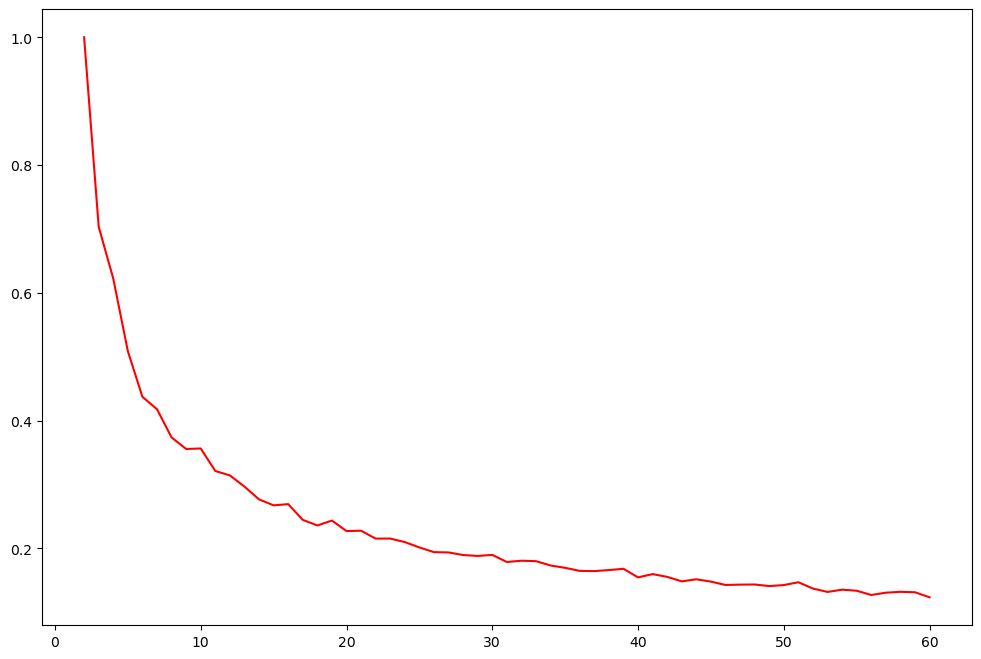

In [229]:
plt.figure(figsize=(12, 8))
plt.plot( [el[0] for el in wss_list] , [el[1]/wss_list[0][1] for el in wss_list], color ='red', label = 'WSS')

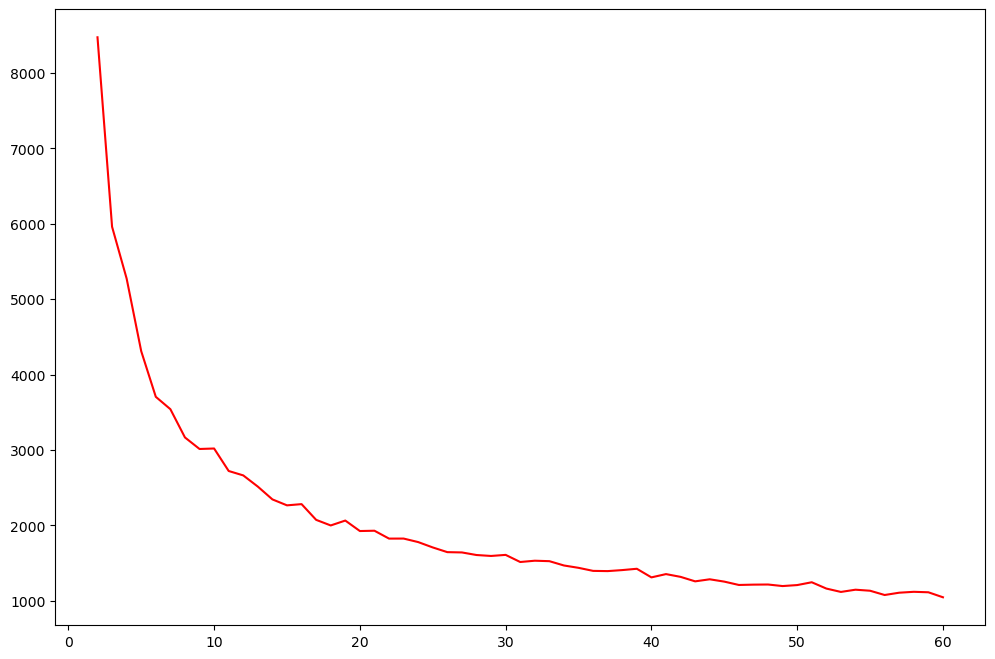

In [230]:
plt.figure(figsize=(12, 8))
plt.plot( [el[0] for el in wss_list] , [el[1] for el in wss_list], color ='red', label = 'WSS')

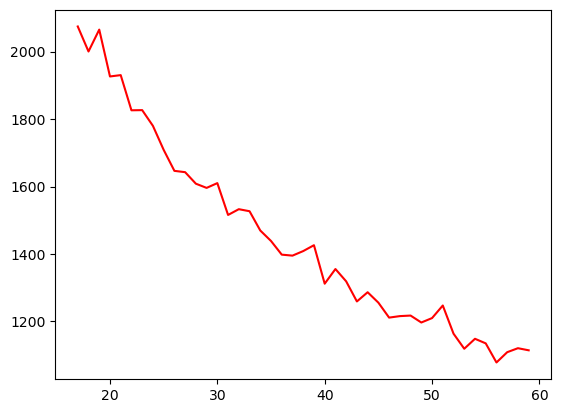

In [234]:
plt.plot( [el[0] for el in wss_list[15:-1]] , [el[1] for el in wss_list[15:-1]], color ='red', label = 'WSS')

In [120]:
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

def tpwd_clustering(Y, c, link='average', normalized=False):
    """
    TPWD_CLUSTERING: Triad Pairwise-Differencing (TPWD) clustering estimator.
    
    Parameters:
    Y : ndarray
        NxT array of possibly unbalanced panel data outcomes.
    c : float
        Nonnegative scalar thresholding parameter.
    link : str, optional
        Linkage criterion ('single', 'complete', 'average'). Default is 'average'.
    normalized : bool, optional
        Whether to use self-normalized distance (True) or raw distance (False). Default is False.
    
    Returns:
    G : int
        Estimated number of groups.
    g : ndarray
        Nx1 array of estimated group memberships.
    """
    N, T = Y.shape
    
    if np.isnan(Y).any():
        print("Warning: Missing values detected. A small value of c may result in a lack of identification.")
    
    if np.any(np.sum(np.isnan(Y), axis=1) > T - 2):
        print("Warning: Some units have less than two observations.")
    
    # Compute matrix of pairwise outcome differences at each time period
    s = np.expand_dims(Y, axis=1) - np.expand_dims(Y, axis=0)  # Shape: (N, N, T)
    
    if normalized:
        s /= np.std(s, axis=2, keepdims=True, where=~np.isnan(s))
    
    # Compute dissimilarity matrix using pairwise differences and triads
    D = np.abs(np.nanmean(Y[:, np.newaxis, np.newaxis, :] * s[np.newaxis, :, :, :], axis=3))
    
    for j in range(N):
        D[j, j, :] = 0
        D[j, :, j] = 0
    
    D = squareform(np.max(D, axis=2))  # Convert to condensed distance matrix
    
    # Perform agglomerative clustering
    W = sch.linkage(D, method=link)
    g = sch.fcluster(W, t=c, criterion='distance')
    G = len(np.unique(g))
    
    return G, g


In [249]:
matrix_to_test = np.array([row for row in (panel_smoothed
                                              .filter(func.col('year').between(1997,2003))
                                              .select('author_id', 'year','citations_raw')
                                              .groupBy('author_id')
                                              .pivot('year')
                                              .agg(func.first('citations_raw'))
                                              .fillna(0)
                                              .drop('author_id')
                                              .collect())])

In [251]:
G, g = tpwd_clustering(matrix_to_test, 0.5, link='average', normalized=False)

MemoryError: Unable to allocate 308. GiB for an array with shape (108692, 108692, 7) and data type int32

In [250]:
matrix_to_test

array([[ 27,   0,  98, ...,  10,   0,  45],
       [ 10,  14,   3, ...,  18,  29,  21],
       [  0,   0,   5, ...,   3,  53,  30],
       ...,
       [  0,   0,   0, ..., 201,   0,   0],
       [  0,   0,   0, ...,  11,   0,   0],
       [  0,   0,   0, ...,   0,   0,   1]])

In [256]:
predicted_k = spark.read.parquet('file:///' +  f'{models_path}k_clusters_model_{8}_{n_f}_quant.pkl')

In [257]:
predicted_k.show()

+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+-------------------+
|    inst_id|                name|         features_ar|n_obs|            features|     scaled_features|  scaled_features_ar|prediction|        sq_distance|
+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+-------------------+
| I100296615|École Nationale d...|[-107.23, -80.018...|   37|[-107.23,-80.018,...|[1.57055341023617...|[1.57055, 1.17963...|         2|0.48337195195306565|
| I102190016|University of New...|[-174.6, -153.15,...|   21|[-174.6,-153.15,-...|[0.24453550610708...|[0.24454, -0.5252...|         6| 0.8862217827990252|
| I102272798|              INSEAD|[-155.64, -64.715...|  122|[-155.64,-64.715,...|[0.61771792353750...|[0.61772, 1.53638...|         3|  9.954260170767556|
| I102475099|             Supélec|[-230.68, -102.82...|  390|[-2

In [258]:
predicted_k.printSchema()

root
 |-- inst_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- features_ar: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- n_obs: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- scaled_features_ar: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- prediction: integer (nullable = true)
 |-- sq_distance: double (nullable = true)



In [259]:
predicted_k.groupBy('prediction').count().sort('prediction').show(30)

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  104|
|         1|   61|
|         2|  209|
|         3|  152|
|         4|  216|
|         5|    8|
|         6|  250|
|         7|  244|
+----------+-----+



In [261]:
predicted_k.filter('prediction=5').select('inst_id','name').show(20, truncate = False)

+-----------+---------------------------------------------------------------------------------+
|inst_id    |name                                                                             |
+-----------+---------------------------------------------------------------------------------+
|I4210106344|Hypertension pulmonaire : physiopathologie et innovation thérapeutique           |
|I4210107937|Immunologie et Neurogénétique Expérimentales et Moléculaires                     |
|I4210116516|Laboratoire de Biologie Cellulaire et Moléculaire du Contrôle de la Prolifération|
|I4210126236|Institute of Paleoprimatology Human Paleontology Evolution and Paleoenvironments |
|I4210151160|Grenoble Institute of Neurosciences                                              |
|I4210152921|Hybrigenics (France)                                                             |
|I4210157800|Génétique Médicale & Génomique Fonctionelle                                      |
|I4210162046|Human Genetic of Infectious

In [106]:
labs_2002_2003_residualized.filter(func.col('inst_id')=="I4210138113").show()

+-----------+----+-----------+----------------+-------------+-------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------+--------+------------------+----------+----------+---------------+------------+--------+-----+----------+-----+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------------+--------------+------------+----------+--------------+---------------+------------+---------------+------+------+------+--------------------+------------------+----------------------+
|  author_id|year|    inst_id|publications_raw|citations_raw|avg_rank_source_raw|nr_source_btm_50pct_r

In [107]:
labs_2002_2003_for_k_means.filter(func.col('inst_id')=="I4210138113").show(truncate = False)

+-----------+-----------------+----------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+
|inst_id    |name             |features_ar                                                                                   |n_obs|features                                                                             |scaled_features                                                                                                                                                                          |scaled_features_ar                                                                            |


In [90]:
predicted_k.filter('prediction=2').select('inst_id','name').show(20, truncate = False)

+-----------+-------------------------------------------------------------------+
|inst_id    |name                                                               |
+-----------+-------------------------------------------------------------------+
|I170429926 |European Science Foundation                                        |
|I3019246885|Centre Hospitalier Universitaire Henri-Mondor                      |
|I4210086514|Unité de Nutrition Humaine                                         |
|I4210090627|Lille’s Cardiology Hospital                                        |
|I4210090932|Physiogenex (France)                                               |
|I4210091534|Institut de Chimie Radicalaire                                     |
|I4210098740|Institut universitaire du cancer de Toulouse Oncopole              |
|I4210104640|Laboratoire de Chimie Moléculaire                                  |
|I4210109499|Zone Atelier Moselle                                               |
|I4210110047|Gen

In [201]:
kmeans = KMeans().setK(9).setSeed(seed)
model_k = kmeans.fit(labs_2002_2003_for_k_means)

Silhouette with squared euclidean distance = 0.08216957019118902
Cluster Centers: 


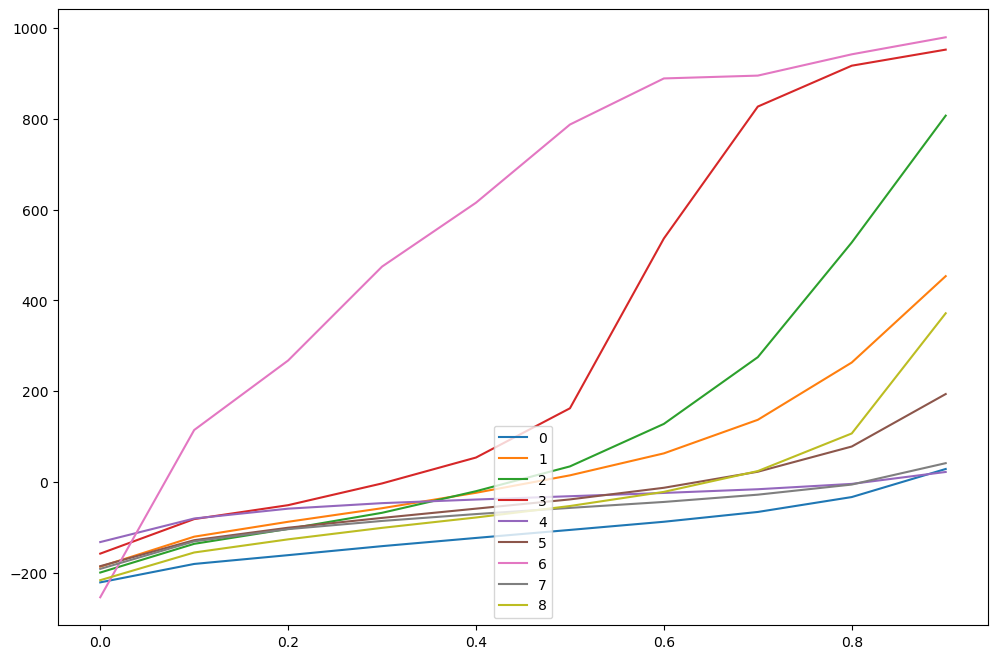

In [202]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predicted_k)
print("Silhouette with squared euclidean distance = " + str(silhouette))
plt.figure(figsize=(12, 8))
# Shows the result.
centers = model_k.clusterCenters()
print("Cluster Centers: ")
for i in range(0,len(centers)):
    plt.plot([i/n_f for i in range(0,n_f)], centers[i], label=i)
plt.legend(loc = 'lower center')

In [203]:
centers

[array([-221.51884817, -180.90756021, -161.52659686, -141.67385864,
        -123.5999267 , -105.93774869,  -87.93709948,  -66.33201047,
         -33.50900524,   28.35375393]),
 array([-187.02842105, -120.80415789,  -87.97856842,  -58.07821053,
         -24.08532632,   14.34073684,   62.7724    ,  136.72864211,
         262.98572632,  453.28029474]),
 array([-199.83962963, -136.58177778, -103.66725926,  -68.196     ,
         -20.60140741,   34.04185185,  127.71118519,  274.79533333,
         527.55874074,  806.99114815]),
 array([-158.17      ,  -82.05628571,  -51.368     ,   -3.47671429,
          53.59257143,  162.10357143,  536.34171429,  826.98485714,
         917.064     ,  952.452     ]),
 array([-132.70032864,  -80.76616901,  -59.076723  ,  -46.9193615 ,
         -38.95301408,  -31.64776995,  -24.43781221,  -16.27752582,
          -4.49748357,   21.79111268]),
 array([-185.79888502, -128.54538328, -101.09691289,  -79.43588153,
         -59.0472892 ,  -38.70726481,  -13.06170732,

In [231]:
euclid_distance = []
for k in range(2,41):
    predicted_k = spark.read.parquet('file:///' +  f'{models_path}k_clusters_model_{k}_{n_f}_quant.pkl')
    evaluator = ClusteringEvaluator()
    
    silhouette = evaluator.evaluate(predicted_k)
    euclid_distance.append(silhouette)
    print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.71095336160396
Silhouette with squared euclidean distance = 0.297605884173073
Silhouette with squared euclidean distance = 0.1565970449813132
Silhouette with squared euclidean distance = 0.157370067587511
Silhouette with squared euclidean distance = 0.17463633283783023
Silhouette with squared euclidean distance = 0.21796990894188514
Silhouette with squared euclidean distance = 0.08447245555372963
Silhouette with squared euclidean distance = 0.10240549891608075
Silhouette with squared euclidean distance = 0.10610883387307353
Silhouette with squared euclidean distance = 0.08208414078981909
Silhouette with squared euclidean distance = 0.09743707288249011
Silhouette with squared euclidean distance = 0.07710624817101495
Silhouette with squared euclidean distance = 0.0764449796673465
Silhouette with squared euclidean distance = 0.09148364844543985
Silhouette with squared euclidean distance = 0.08292477819929697
Silhouette with squared euclidean 

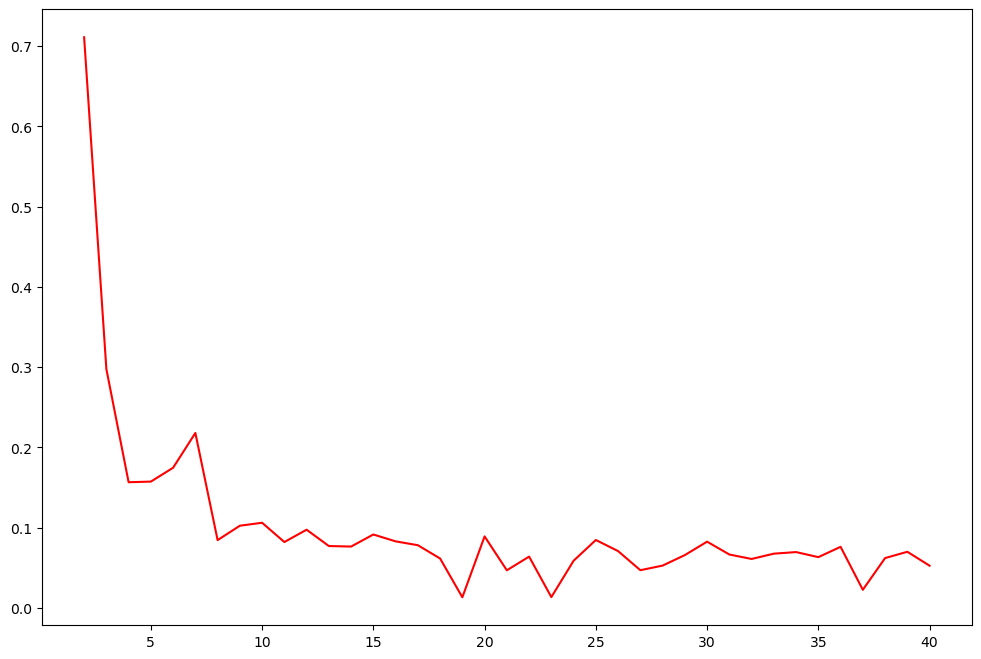

In [232]:
plt.figure(figsize=(12, 8))
plt.plot( range(2,41) , euclid_distance, color ='red')